# Setup

In [1]:
import multiprocessing as mp

from transformers import AutoTokenizer, BertForMaskedLM, pipeline
import torch
import os
import math
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
home_path = "../zeste/"

In [3]:
numberbatch = pickle.load(open(home_path+"numberbatch-en-19.08-en.pickle", 'rb'))

In [94]:
def softmax(v):
    e = np.exp(v)
    return e / np.sum(e)


def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens


def get_LM_neighborhood(label, prompt, prompt_mapping):
    candidates_scores = {}
    
    template = f"{prompt} [SEP] {prompt_mapping[label]} related to {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    best_score = np.max(scores)
    candidates_scores = sorted([(reverse_vocab[i], s/best_score) for i,s in enumerate(scores)], key=lambda c: -c[1])

    neighborhood = dict(candidates_scores)
    neighborhood[label] = 1.0
    
    return neighborhood


def get_LM_neighborhood_softmax(label, prompt, prompt_mapping):
    candidates_scores = {}
    
    template = f"{prompt} [SEP] {prompt_mapping[label]} related to {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    best_score = np.max(scores)
    candidates_scores = sorted([(reverse_vocab[i], s) for i,s in enumerate(softmax(scores))], key=lambda c: -c[1])

    neighborhood = dict(candidates_scores)
    neighborhood[label] = 1.0
    
    return neighborhood


def get_conceptnet_neighborhood(word, depth=2, allowed_rels='all', keep='top20000'):
    neighborhood_all = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood_all.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in get_word_neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood_all[n]
                continue
    
    neighborhood_words = list(neighborhood_all.keys())
    neighborhood = {w: neighborhood_all[w]['sim'] for w in neighborhood_words}

    to_visit_next = neighborhood_words

    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_conceptnet_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww not in neighborhood:
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww] = numberbatch.similarity(word, ww)
                        additions.append(ww)
                    else:
                        neighborhood[ww] = 0.0
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood


def get_filtered_neighborhood_1hop(word, prompt, prompt_mapping, depth=2, lm_top=3000, allowed_rels='all', keep='top20000'):
    neighborhood_all = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood_all.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in get_word_neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood_all[n]
                continue
    
    neighborhood_words = list(neighborhood_all.keys())
    neighborhood = {w: neighborhood_all[w]['sim'] for w in neighborhood_words}
    
    lmn = get_LM_neighborhood(word, prompt, prompt_mapping)
    
    lmn_top = dict(sorted(lmn.items(), key=lambda x: -x[1])[:lm_top])
    neighborhood = {w:s for w,s in neighborhood.items() if w in lmn_top}
    to_visit_next = list(neighborhood.keys())

    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_conceptnet_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww not in neighborhood:
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww] = numberbatch.similarity(word, ww)
                        additions.append(ww)
                    else:
                        neighborhood[ww] = 0.0
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood


def get_LM_neighborhood_classification(label, prompt, prompt_mapping, cn_neighborhood, n_classes = 100):
    neighborhood = {}

    cnn_len = len(cn_neighborhood)
    n_steps = math.ceil(cnn_len/n_classes)

    for i in range(n_steps):
        candidate_labels = list(cn_neighborhood.keys())[i*n_classes:(i+1)*n_classes]
        candidate_labels = [candidate.replace('_', ' ') for candidate in candidate_labels]

        sequence = f"{datasets[ds]['prompts'][label]}"
        hypothesis = f"{datasets[ds]['prompt_mapping'][label]}"+" about {}."

        torch.cuda.empty_cache()

        results = zs_classifier(sequence, candidate_labels, hypothesis, multi_label=True)
        results['labels'] = [candidate.replace(' ', '_') for candidate in results['labels']]
        results_score = dict(zip(results['labels'], results['scores'])) 

        for candidate in results_score:
            neighborhood[candidate] = results_score[candidate]
    
    return neighborhood


def get_LM_neighborhood_classification_2(label, prompt, prompt_mapping, cn_neighborhood, n_classes = 100):
    neighborhood = {}

    cnn_len = len(cn_neighborhood)
    n_steps = math.ceil(cnn_len/n_classes)

    for i in range(n_steps):
        candidate_labels = list(cn_neighborhood.keys())[i*n_classes:(i+1)*n_classes]
        candidate_labels = [candidate.replace('_', ' ') for candidate in candidate_labels]

        sequence = f"{datasets[ds]['prompts'][label]} {datasets[ds]['prompt_mapping'][label]}"
        hypothesis = "The text is about {}."

        torch.cuda.empty_cache()

        results = zs_classifier(sequence, candidate_labels, hypothesis, multi_label=True)
        results['labels'] = [candidate.replace(' ', '_') for candidate in results['labels']]
        results_score = dict(zip(results['labels'], results['scores'])) 

        for candidate in results_score:
            neighborhood[candidate] = results_score[candidate]
    
    return neighborhood

In [5]:
options = {
    'model_name': 'bert-large-uncased',#'bert-base-uncased',
    'prompt': {},
}

In [6]:
tokenizer = AutoTokenizer.from_pretrained(options['model_name'])
bert = BertForMaskedLM.from_pretrained(options['model_name'])

bert_vocab = tokenizer.get_vocab()
reverse_vocab = {i:w for w,i in bert_vocab.items()}
len(bert_vocab)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30522

# Preparing all the Datasets

## 20 NewsGroup

In [7]:
ds_ng20 = pd.read_csv(home_path+'datasets/20ng_preprocessed_dataset.csv')
ds_ng20.head()

Unnamed: 0                  label  \
0           0              rec.autos   
1           1  comp.sys.mac.hardware   
2           2  comp.sys.mac.hardware   
3           3          comp.graphics   
4           4              sci.space   

                                                text  
0  car wondering anyone could enlighten car saw d...  
1  clock poll final call summary final call clock...  
2  question well folk mac plus finally gave ghost...  
3  weitek robert kyanko wrote writes far low leve...  
4  shuttle launch question error wondering expect...

In [8]:
print('Original Labels: ', list(ds_ng20.label.unique()), '\n')

Original Labels:  ['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc', 'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x', 'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian', 'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'] 



In [9]:
ng20_mapping = {  'alt.atheism': 'atheism', # 'atheism',
                 'comp.graphics': 'graphic',
                 'comp.os.ms-windows.misc': 'windows',
                 'comp.sys.ibm.pc.hardware': 'hardware',
                 'comp.sys.mac.hardware': 'hardware',
                 'comp.windows.x': 'windows',
                 'misc.forsale': 'sale',
                 'rec.autos': 'car',
                 'rec.motorcycles': 'motorcycle',
                 'rec.sport.baseball': 'baseball',
                 'rec.sport.hockey': 'hockey',
                 'sci.crypt': 'cryptography',
                 'sci.electronics': 'electronics',
                 'sci.med': 'medicine',
                 'sci.space': 'space',
                 'soc.religion.christian': 'christianity',
                 'talk.politics.guns': 'gun',
                 'talk.politics.mideast': 'middle_east',
                 'talk.politics.misc': 'politics',
                 'talk.religion.misc': 'religion' }

ng20_labels = sorted(set(ng20_mapping.values()))
print(ng20_labels)

['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [10]:
ng20_prompt_mapping = {'atheism':'Atheism is', 
                      'baseball':'Baseball is', 
                      'car': 'Car are', 
                      'christianity': 'Christianity is', 
                      'cryptography': 'Cryptography is', 
                      'electronics': 'Electronics are', 
                      'graphic': 'Graphics are', 
                      'gun': 'Guns are', 
                      'hardware': 'Hardware is', 
                      'hockey': 'Hockey is', 
                      'medicine': 'Medicine is', 
                      'middle_east': 'The Middle East is', 
                      'motorcycle': 'Motorcycles are', 
                      'politics': 'Politics are', 
                      'religion': 'Religion is', 
                      'sale': 'Sales are', 
                      'space': 'Space is', 
                      'windows': 'Windows is'
}


print('Final labels:', ng20_labels, '\n')
print('Final number of labels:', len(ng20_labels), '\n')
print("Sample:", ds_ng20.values[0])

Final labels: ['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows'] 

Final number of labels: 18 

Sample: [0 'rec.autos'
 'car wondering anyone could enlighten car saw day door sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car made history whatever info funky looking car please mail thanks brought neighborhood lerxst']


In [11]:
ng20_prompts = {}
ng20_prompts['atheism'] = 'Disbelief or lack of belief in the existence of God or gods.'
ng20_prompts['baseball'] = 'Baseball is a bat-and-ball game played between two opposing teams, typically of nine players each, that take turns batting and fielding.'
ng20_prompts['car'] = 'A car or automobile is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one-to-eight people, have four wheels and mainly transport people rather than goods.'
ng20_prompts['christianity'] = 'Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world\'s largest religion.'
ng20_prompts['cryptography'] = 'Cryptography or cryptology is the practice and study of techniques for secure communication in the presence of adversarial behavior.'
ng20_prompts['electronics'] = 'Electronics comprises the physics, engineering, technology and applications that deal with the emission, flow and control of electrons in vacuum and matter.'
ng20_prompts['graphic'] = 'Graphics are visual images or designs on some surface, such as a wall, canvas, screen, paper, or stone to inform, illustrate, or entertain. It includes a pictorial representation of data, as in design and manufacture, in typesetting and the graphic arts, and in educational and recreational software.'
ng20_prompts['gun'] = 'A gun is a ranged weapon designed to use a shooting tube (gun barrel) to launch typically solid projectiles'
ng20_prompts['hardware'] = 'Computer hardware includes the physical parts of a computer, such as the case, central processing unit (CPU), monitor, mouse, keyboard, computer data storage, graphics card, sound card, speakers and motherboard.'
ng20_prompts['hockey'] = 'Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent\'s goal using a hockey stick.'
ng20_prompts['medicine'] = 'Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment, palliation of their injury or disease, and promoting their health.'
ng20_prompts['middle_east'] = 'The Middle East is a geopolitical term that commonly refers to the region spanning the Levant, Arabian Peninsula, Anatolia (including modern Turkey and Cyprus), Egypt, Iran and Iraq.'
ng20_prompts['motorcycle'] = 'A motorcycle, often called a motorbike, bike, or cycle, is a two- or three-wheeled motor vehicle.'
ng20_prompts['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
ng20_prompts['religion'] = 'Religion is a social-cultural system of designated behaviors and practices, morals, beliefs, worldviews, texts, sanctified places, prophecies, ethics, or organizations, that relates humanity to supernatural, transcendental, and spiritual elements.'
ng20_prompts['sale'] = 'Sales are activities related to selling or the number of goods sold in a given targeted time period. The delivery of a service for a cost is also considered a sale.'
ng20_prompts['space'] = 'Outer space is the expanse that exists beyond Earth and between celestial bodies.'
ng20_prompts['windows'] = 'Windows is a group of several proprietary graphical operating system families, all of which are developed and marketed by Microsoft. Each family caters to a certain sector of the computing industry.'

## AFP

In [12]:
ds_afp = pd.read_csv(home_path+'datasets/afp_mono_en.csv')
ds_afp.head()

Unnamed: 0                                               text     label
0           0  first nasa spaceship begin orbit asteroid nasa...  13000000
1           1  nasa speed toward historic flyby faraway world...  13000000
2           2  spacecraft zoom distant world ever studied nas...  13000000
3           3  nasa ring new year historic flyby faraway worl...  13000000
4           4  spacecraft survived distant flyby space rock n...  13000000

## AG News

In [13]:
ds_ag = pd.read_csv(home_path+'datasets/ag_test_dataset.csv')
ds_ag.head()

Unnamed: 0                                               text     label
0           0  Fears for T N pension after talks - Unions rep...  Business
1           1  The Race is On: Second Private Team Sets Launc...  Sci/Tech
2           2  Ky. Company Wins Grant to Study Peptides (AP) ...  Sci/Tech
3           3  Prediction Unit Helps Forecast Wildfires (AP) ...  Sci/Tech
4           4  Calif. Aims to Limit Farm-Related Smog (AP) - ...  Sci/Tech

In [14]:
print('Original Labels: ', list(ds_ag.label.unique()), '\n')

Original Labels:  ['Business', 'Sci/Tech', 'Sports', 'World'] 



In [15]:
ag_mapping = { 'Business': 'business',
                 'Sci/Tech': 'technology',
                 'Sports': 'sport',
                 'World': 'politics',}

ag_labels = sorted(set(ag_mapping.values()))
ag_labels

['business', 'politics', 'sport', 'technology']

In [16]:
ag_prompt_mapping = {'business': 'Business is', 
                     'politics': 'Politics are', 
                     'technology': 'Technology is', 
                     'sport': 'Sports are',
}

assert(sorted(list(ag_prompt_mapping.keys())) == ag_labels)

print('Final labels:', ag_labels, '\n')
print('Final number of labels:', len(ag_labels), '\n')
print("Sample:", ds_ag.values[0])

Final labels: ['business', 'politics', 'sport', 'technology'] 

Final number of labels: 4 

Sample: [0
 "Fears for T N pension after talks - Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
 'Business']


In [17]:
ag_prompts = {}
ag_prompts['sport'] = 'Sport pertains to any form of competitive physical activity or game that aims to use, maintain or improve physical ability and skills while providing enjoyment to participants and, in some cases, entertainment to spectators.'
ag_prompts['technology'] = 'Technology is the sum of any techniques, skills, methods, and processes used in the production of goods or services or in the accomplishment of objectives, such as scientific investigation. Technology can be the knowledge of techniques, processes, and the like, or it can be embedded in machines to allow for operation without detailed knowledge of their workings.'
ag_prompts['business'] = 'Business is the activity of making one\'s living or making money by producing or buying and selling products (such as goods and services). Simply put, it is any activity or enterprise entered into for profit.'
ag_prompts['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'

## BBC News

In [18]:
ds_bbc = pd.read_csv(home_path+'datasets/bbc_dataset.csv')
ds_bbc.head()

text label
0  Technology gets the creative bug  The hi-tech ...  tech
1  UK pioneers digital film network  The world's ...  tech
2  Movie body hits peer-to-peer nets  The movie i...  tech
3  Who do you think you are?  The real danger is ...  tech
4  Tough rules for ringtone sellers  Firms that f...  tech

In [19]:
print('Original Labels: ', list(ds_bbc.label.unique()), '\n')

Original Labels:  ['tech', 'sport', 'business', 'entertainment', 'politics'] 



In [20]:
bbc_mapping = {  'tech': 'technology',
                 'entertainment': 'entertainment',
                 'sport': 'sport',
                 'business': 'business',
                 'politics': 'politics'}

bbc_labels = sorted(set(bbc_mapping.values()))
bbc_labels

['business', 'entertainment', 'politics', 'sport', 'technology']

In [21]:
bbc_prompt_mapping = {'technology': 'Technology is', 
                      'entertainment': 'Entertainment is', 
                      'sport': 'Sports are', 
                      'business': 'Business is',
                      'politics': 'Politics are'
}

assert(sorted(list(bbc_prompt_mapping.keys())) == bbc_labels)

print('Final labels:', bbc_labels, '\n')
print('Final number of labels:', len(bbc_labels), '\n')
print("Sample:", ds_bbc.values[2])

Final labels: ['business', 'entertainment', 'politics', 'sport', 'technology'] 

Final number of labels: 5 

Sample: ['Movie body hits peer-to-peer nets  The movie industry has struck out at file-sharing networks with another round of lawsuits in the US.  The Motion Picture Association of America (MPAA) also said it had succeeded in getting a network called LokiTorrent closed down. It is the latest network which uses the peer-to-peer system called BitTorrent to be hit by the MPAA. The MPAA began its legal campaign against operators of similar networks across four continents in December. A Dallas court agreed that Hollywood lawyers would be allowed access to LokiTorrent\'s server records which could let them single out those who were sharing files illegally. In October 2004, the site had provided links to more than 30,000 files. The action came after the operators of LokiTorrent agreed a settlement with the MPAA. A stark message has appeared on the site from the MPAA warning "You can cl

In [22]:
bbc_prompts = {}
bbc_prompts['sport'] = 'Sport pertains to any form of competitive physical activity or game that aims to use, maintain or improve physical ability and skills while providing enjoyment to participants and, in some cases, entertainment to spectators.'
bbc_prompts['technology'] = 'Technology is the sum of any techniques, skills, methods, and processes used in the production of goods or services or in the accomplishment of objectives, such as scientific investigation. Technology can be the knowledge of techniques, processes, and the like, or it can be embedded in machines to allow for operation without detailed knowledge of their workings.'
bbc_prompts['business'] = 'Business is the activity of making one\'s living or making money by producing or buying and selling products (such as goods and services). Simply put, it is any activity or enterprise entered into for profit.'
bbc_prompts['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
bbc_prompts['entertainment'] = 'Entertainment is a form of activity that holds the attention and interest of an audience or gives pleasure and delight.'

## Crime Scene Aspects

In [88]:
path_screenplays_scenes = '/data/screenplay_sum/screenplay_summarization/scene_level_n_aspects'
li = []

for ep in os.listdir(path_screenplays_scenes):
    annotated_scenes=pd.read_csv(path_screenplays_scenes+'/'+ep)
    df_with_aspects=(annotated_scenes.loc[annotated_scenes['aspects'] !="None"])
    li.append(df_with_aspects)
    
df_scenes_with_aspects = pd.concat(li, axis=0, ignore_index=True)
ds_crime = df_scenes_with_aspects[['scene_text', 'aspects']].rename({'scene_text': 'text', 'aspects':'label'})
ds_crime['label'] = ds_crime['aspects']
ds_crime['text'] = ds_crime['scene_text']
ds_crime = ds_crime[['text', 'label']]
ds_crime

text  \
0    [" ( There 's a dead woman 's body in the wate...   
1    [' ( Brass interviews Dan Keaton who is moanin...   
2    [' ( Nick and Warrick duck under the crime sce...   
3    [' ( Robbins finishes stitching up the Y-incis...   
4    [' ( Det Cavaliere interviews Charlie Pinscher...   
..                                                 ...   
444  [' ( DAVID PHILLIPS moves the head to check th...   
445  [' ( Through the window , we see WARRICK and B...   
446  [' ( BRASS interviews JOSEPH GREENE . )', " [[...   
447  [' ( Inside the holding cell , SETH LANDERS si...   
448  [' ( Open on the taped up door handle . )', ' ...   

                              label  
0                Crime scene,Victim  
1                       Perpetrator  
2    Crime scene,Victim,Perpetrator  
3                       Death cause  
4                Victim,Perpetrator  
..                              ...  
444                     Death cause  
445                        Evidence  
446                          Motive  
447                        Evidence  
448                        Evidence  

[449 rows x 2 columns]

In [49]:
set([l for ls in ds_crime.aspects.unique() for l in ls.split(',')])

{'Crime scene', 'Death cause', 'Evidence', 'Motive', 'Perpetrator', 'Victim'}

In [54]:
crime_mapping = {'Crime scene': 'crime_scene',
                 'Death cause': 'cause_of_death',
                 'Evidence': 'evidence',
                 'Motive': 'motive',
                 'Perpetrator': 'perpetrator',
                 'Victim': 'victim',}

crime_labels = sorted(set(crime_mapping.values()))
crime_labels

['cause_of_death',
 'crime_scene',
 'evidence',
 'motive',
 'perpetrator',
 'victim']

In [57]:
crime_prompt_mapping = {'motive': 'A crime motive is',
                     'evidence': 'A crime evidence is',
                     'cause_of_death': 'A cause of death is',
                     'perpetrator': 'A crime perpetuator is',
                     'victim': 'A crime victim is',
                     'crime_scene': 'A crime scene is',
}

assert(sorted(list(crime_prompt_mapping.keys())) == crime_labels)

print('Final labels:', crime_labels, '\n')
print('Final number of labels:', len(crime_labels), '\n')
print("Sample:", ds_crime.values[0])

Final labels: ['cause_of_death', 'crime_scene', 'evidence', 'motive', 'perpetrator', 'victim'] 

Final number of labels: 6 

Sample: ['[" ( There \'s a dead woman \'s body in the water fountain in the center of the road . )", \' ( David Phillips leans over the edge of the fountain as he waits for the water to be turned off . )\', \' ( Brass walks up to him . )\', " [[Brass]] what \'s the matter ?", " [[Brass]] ca n\'t do your work ?", " [[Brass]] hey , fellas , what \'s the holdup ?", \' [[Brass]] come on\', \' [[Brass]] i told you half an hour ago turn the damn fountain off !\', \' [[Brass]] give me a break\', \' ( Together , Grissom and Sara duck under the crime scene tape on the way to the fountain Just outside the tape are the party-goers . )\', \' ( Grissom puts his kit down . )\', " [[Brass]] you ca n\'t find good help", " [[Grissom]] as lord byron once said , \'in the desert , a fountain is springing \'", \' [[Brass]] well , this one sprung a dead woman ... vanessa keaton\', \' 

In [59]:
crime_prompts = {}
crime_prompts['motive'] = 'In law, A motive is the cause that moves people to induce a certain action.'
crime_prompts['evidence'] = 'The law of evidence, also known as the rules of evidence, encompasses the rules and legal principles that govern the proof of facts in a legal proceeding.'
crime_prompts['cause_of_death'] = 'In law, cause of death is an official determination of conditions resulting in a human\'s death, which may be recorded on a death certificate. '
crime_prompts['perpetrator'] = 'A perpetuator is someone who committed a crime.'
crime_prompts['victim'] = 'In criminology and criminal law, a victim of a crime is an identifiable person who has been harmed individually and directly by the perpetrator, rather than by society as a whole.'
crime_prompts['crime_scene'] = 'A crime scene is any location that may be associated with a committed crime.'

## Situations

In [50]:
path_dataset = 'situation/test.txt'
ds_situations = pd.read_csv(path_dataset,sep='\t',header=None,names=["label", "text"])
ds_situations.label = ds_situations.label.str.replace(' ', ',')
ds_situations = ds_situations[ds_situations['label'] != 'out-of-domain']

ds_situations

label  \
1                                       shelter   
2                                       shelter   
3                                          food   
4                                         utils   
6                                         water   
...                                         ...   
3306                            search,med,evac   
3307              water,med,search,shelter,food   
3308  water,med,search,shelter,infra,utils,food   
3309                                    shelter   
3310                         search,med,shelter   

                                                   text  
1     residents have taken shelter in mosques , scho...  
2     major nigel cribb , commanding officer of 59 c...  
3     two c-130 transports left subang yesterday wit...  
4     furthermore , a 150 kilovolt-ampere generator ...  
6     vegetation normally found around small waterin...  
...                                                 ...  
3306  Under the nurture of the Party and the army, t...  
3307  Hiding information is not advisable even if th...  
3308  Sometime past 4 o'clock, I read the online new...  
3309  Lately, I've been watching live broadcasts eve...  
3310  Elementary schools and middle schools in Japan...  

[2343 rows x 2 columns]

In [26]:
set([l for ls in ds_situations.label.unique() for l in ls.split(',')])

{'crimeviolence',
 'evac',
 'food',
 'infra',
 'med',
 'out-of-domain',
 'regimechange',
 'search',
 'shelter',
 'terrorism',
 'utils',
 'water'}

In [51]:
situations_mapping = {'crimeviolence': 'crime',
                 'evac': 'evacuation',
                 'food': 'food',
                 'infra': 'infrastructure',
                 'med': 'medics',
                 'regimechange': 'regime_change',
                 'search': 'rescue',
                 'shelter': 'shelter',
                 'terrorism': 'terrorism',
                 'utils': 'utilities',
                 'water': 'water'}

situations_labels = sorted(set(situations_mapping.values()))
situations_labels

['crime',
 'evacuation',
 'food',
 'infrastructure',
 'medics',
 'regime_change',
 'rescue',
 'shelter',
 'terrorism',
 'utilities',
 'water']

In [52]:
situations_prompt_mapping = {'crime': 'Crime and violence are',
                     'evacuation': 'Evacuation is',
                     'food': 'Food supply is',
                     'infrastructure': 'Infrastructure is',
                     'medics': 'Medical assistance is',
                     'regime_change': 'Regime change is',
                     'rescue': 'Search/rescue mission is',
                     'shelter': 'Shelter is',
                     'terrorism': 'Terrorism is',
                     'utilities': 'Utilities, energy, or sanitation are',
                     'water': 'Water supply is'
}

assert(sorted(list(situations_prompt_mapping.keys())) == situations_labels)

print('Final labels:', situations_labels, '\n')
print('Final number of labels:', len(situations_labels), '\n')
print("Sample:", ds_situations.values[2])

Final labels: ['crime', 'evacuation', 'food', 'infrastructure', 'medics', 'regime_change', 'rescue', 'shelter', 'terrorism', 'utilities', 'water'] 

Final number of labels: 11 

Sample: ['food'
 'two c-130 transports left subang yesterday with shipments of fortified biscuits , bound for banda aceh .']


In [60]:
situations_prompts = {}
situations_prompts['crime'] = 'A crime is an unlawful act punishable by a state or other authority. ... One proposed definition is that a crime or offence (or criminal offence) is an act harmful not only to some individual but also to a community, society, or the state.'
situations_prompts['evacuation'] = 'Emergency evacuation is the urgent immediate egress or escape of people away from an area that contains an imminent threat, an ongoing threat or a hazard to lives or property.'
situations_prompts['food'] = 'Food security is the measure of the availability of food and individuals\' ability to access it.'
situations_prompts['infrastructure'] = 'Infrastructure is the set of fundamental facilities and systems that support the sustainable functionality of households and firms. Serving a country, city, or other area, including the services and facilities necessary for its economy to function.'
situations_prompts['medics'] = 'A medic is a person involved in medicine such as a medical doctor, medical student, paramedic or an emergency medical responder.'
situations_prompts['regime_change'] = 'Business is the activity of making one\'s living or making money by producing or buying and selling products (such as goods and services). Simply put, it is any activity or enterprise entered into for profit.'
situations_prompts['rescue'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
situations_prompts['shelter'] = 'A shelter is a basic architectural structure or building that provides protection from the local environment.'
situations_prompts['terrorism'] = 'Terrorism is the unlawful use of intentional violence to achieve political aims'
situations_prompts['utilities'] = 'Public utilities are meant to supply goods/services that are considered essential; water, gas, electricity, telephone, and other communication systems represent much of the public utility market.'
situations_prompts['water'] = 'A water supply network or water supply system is a system of engineered hydrologic and hydraulic components that provide water supply.'

## Silknow 

In [27]:
! ls ../zeste/datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


### Silk Material

In [65]:
ds_silk_material = pd.read_csv('silknow/en_material_post2.csv')
ds_silk_material.head()

obj museum  \
0  http://data.silknow.org/object/c8ea7e82-2048-3...    met   
1  http://data.silknow.org/object/53e251b9-2d49-3...    met   
2  http://data.silknow.org/object/c70ff016-0e24-3...    met   
3  http://data.silknow.org/object/c66fcc1f-8c36-3...    met   
4  http://data.silknow.org/object/c6243b95-a127-3...    met   

                                                text    label  
0  The textile used in this chasuble is a beautif...  Textile  
1  "Italian" is one of the rare textiles by Owen ...  Textile  
2  The textile used in this chasuble, stole, and ...  Textile  
3  This object is from the collection of Natalia ...  Textile  
4  Panels such as this—with its extraordinary pat...  Textile

In [66]:
print('Original Labels: ', list(ds_silk_material.label.unique()), '\n')

Original Labels:  ['Textile', 'Wool', 'Cotton', 'Metal silver thread', 'Metal thread', 'Silver thread', 'Gold thread'] 



In [67]:
silk_material_mapping = {'Textile':'textile', 
                         'Wool':'wool', 
                         'Cotton': 'cotton', 
                         'Metal silver thread': 'silver', 
                         'Metal thread': 'metal', 
                         'Silver thread': 'silver', 
                         'Gold thread': 'gold'}

silk_material_labels = sorted(set(silk_material_mapping.values()))
silk_material_labels

['cotton', 'gold', 'metal', 'silver', 'textile', 'wool']

In [31]:
silk_material_prompt_mapping = {'gold': 'Gold is', 
                                'silver': 'Silver is'
                               }

assert(sorted(list(silk_material_prompt_mapping.keys())) == silk_material_labels)

print('Final labels:', silk_material_labels, '\n')
print('Final number of labels:', len(silk_material_labels), '\n')
print("Sample:", ds_silk_material.values[0])

Final labels: ['gold', 'silver'] 

Final number of labels: 2 

Sample: ['Silk brocade textile, Varanasi, 19th Century.' "'Gold thread'"]


In [68]:
silk_material_prompt_mapping = {'textile':'Textile is', 
                                 'wool':'Wool is', 
                                 'cotton': 'Cotton is', 
                                 'silver': 'Silver is', 
                                 'metal': 'Metal is', 
                                 'gold': 'Gold is'
                               }

assert(sorted(list(silk_material_prompt_mapping.keys())) == silk_material_labels)

print('Final labels:', silk_material_labels, '\n')
print('Final number of labels:', len(silk_material_labels), '\n')
print("Sample:", ds_silk_material.values[0])

Final labels: ['cotton', 'gold', 'metal', 'silver', 'textile', 'wool'] 

Final number of labels: 6 

Sample: ['http://data.silknow.org/object/c8ea7e82-2048-360c-afd7-9ed335e7f7aa'
 'met'
 'The textile used in this chasuble is a beautiful example of elaborate weaving. Here the use of cut and uncut velvet is used to delineate the interior layers of the flowers, which gives them a rich and dimensional appearance. The use of metallic bouclé to provide an additional level of patterning also shows a high level of weaving acumen. The curvilinear pattern known as ferronerie is used here on the main fabric of the chasuble. Ferronerie was prevalent in textile design during the Renaissance and reflected the ornate ironwork of the period.'
 'Textile']


In [74]:
silk_material_prompts = {}
silk_material_prompts['gold'] = 'Gold thread composed of a gold lamella, approximately 1mm wide rolled or wound around a silk core.'
silk_material_prompts['silver'] = 'Silver thread composed of a silver lamella, approximately 1mm wide rolled or wound around a silk core.'
silk_material_prompts['metal'] = 'Metal thread denotes any thread that has a metal or metallic component in part or entirely.'
silk_material_prompts['cotton'] = 'Cotton refers to a white fibrous substance, a vegetable seed fiber, soft and downy like wool..'
silk_material_prompts['textile'] = 'Textile refers to a woven fabric.'
silk_material_prompts['wool'] = 'Wool means the covering coat of the domesticated sheep, that can also be known as fleece.'

### Silk Technique

In [69]:
ds_silk_technique ds_crime= pd.read_csv('silknow/en_technique_post2.csv')
ds_silk_technique.head()

obj museum  \
0  http://data.silknow.org/object/769331b8-9280-3...    met   
1  http://data.silknow.org/object/3a1a13d2-4f9c-3...    met   
2  http://data.silknow.org/object/d0a69b79-3155-3...    met   
3  http://data.silknow.org/object/6d88a8ff-69f0-3...    met   
4  http://data.silknow.org/object/3992f756-4db0-3...    met   

                                                text       label  
0  The settees and chairs illustrated here (see 1...      Velvet  
1  This object is from the collection of Natalia ...  Embroidery  
2  This orphrey band is an extraordinary example ...  Embroidery  
3  The initials S.B. in the center of this elabor...  Embroidery  
4  This elaborately embroidered purse probably co...  Embroidery

In [70]:
print('Original Labels: ', list(ds_silk_technique.label.unique()), '\n')

Original Labels:  ['Velvet', 'Embroidery', 'Satin (fabric)', 'Damask', 'Brocaded', 'Tabby (silk weave)', 'Muslin', 'Voided velvet'] 



In [71]:
silk_technique_mapping = {'Embroidery': 'embroidery', 
                         'Velvet': 'velvet', 
                         'Satin (fabric)': 'satin', 
                         'Damask': 'damask', 
                         'Brocaded': 'brocaded', 
                         'Tabby (silk weave)': 'tabby', 
                         'Muslin': 'muslin', 
                         'Voided velvet': 'velvet'}

silk_technique_labels = sorted(set(silk_technique_mapping.values()))
silk_technique_labels

['brocaded', 'damask', 'embroidery', 'muslin', 'satin', 'tabby', 'velvet']

In [72]:
silk_technique_prompt_mapping = {'brocaded': 'Brocaded weave is', 
                                'damask': 'Damask weave is', 
                                'embroidery': 'Embroidery is', 
                                'muslin': 'Muslin in', 
                                'satin': 'Satin silk weave is', 
                                'tabby': 'Tabby weave is', 
                                'velvet': 'Velvet is'
                               }

assert(sorted(list(silk_technique_prompt_mapping.keys())) == silk_technique_labels)

print('Final labels:', silk_technique_labels, '\n')
print('Final number of labels:', len(silk_technique_labels), '\n')
print("Sample:", ds_silk_technique.values[0])

Final labels: ['brocaded', 'damask', 'embroidery', 'muslin', 'satin', 'tabby', 'velvet'] 

Final number of labels: 7 

Sample: ['http://data.silknow.org/object/769331b8-9280-3ffa-84b2-fded34673b77'
 'met'
 'The settees and chairs illustrated here (see 1974.356.114–.121) were made for the Franckenstein Pavilion in the gardens of Seehof Castle near Bamberg, one of the three summer residences in Southern Germany used by Adam Friedrich von Seinsheim, prince bishop of Würzberg and Bamberg. A true garden enthusiast, it was under von Seinsheim that the gardens of Seehof were embellished, which must have resembled the still extant Rococo gardens completed by von Seinsheim at Veitshöchheim. His love for gardens and garden imagery also carried over into the interior decoration and furnishings of his castles, as the Seehof furniture demonstrates. A unique example of German Rococo furniture executed in a more flamboyant style than its French prototypes, the ensemble was designed specifically for t

In [73]:
silk_technique_prompts = {}
silk_technique_prompts['brocaded'] = 'Brocaded is the action of weaving with a brocading weft, adding a supplementary weft introduced into a ground weave.'
silk_technique_prompts['damask'] = 'Damask could refer simply to silk, but the term referred to a weave with two faces, reversible, made from several fibres and colours. Different layouts make the contrast, the warp-float and the weft-float, shaped with same thickness, colour and quality threads. Originally, the term damask indicated procedence from the city of Damascus.'
silk_technique_prompts['embroidery'] = 'Embroidery is an art of ornamenting cloths and other fabrics\' ground with needle-worked accesory stitches made with thread, yarn or other flexible materials. From the many types of stitches straight running stitch, backstitch, satin stitch, couching stitch, cross-stitch, chain-stitch, can be named.'
silk_technique_prompts['muslin'] = 'Muslin can refer to the various lightweight cotton, cotton blend or silk fabrics in a plain weave, from the most lightweight sheers to the heavyweight sheetings.'
silk_technique_prompts['satin'] = 'Satin is basic binding system or weave structure in which the threads of the warp are caught and looped by the weft only at certain intervals.'
silk_technique_prompts['tabby'] = 'Tabby is a form of binding or weave, composed of one set of warps and one set of wefts in which each end passes over one and under one pick.'
silk_technique_prompts['velvet'] = 'Velvet refers to a silk textile fabric that has a short, dense and smooth piled surface.'

In [38]:
datasets = {'ng20': {}, 'ag': {}, 'bbc': {}, 'silk_material': {}, 'silk_technique': {}, 'situations': {}, 'crime': {}} # AFP, Crime, Situation, 

for ds in datasets:
    exec(f"datasets['{ds}']['df'] = ds_{ds}")
    exec(f"datasets['{ds}']['labels'] = {ds}_labels")
    exec(f"datasets['{ds}']['mapping'] = {ds}_mapping")
    exec(f"datasets['{ds}']['prompt_mapping'] = {ds}_prompt_mapping")
    exec(f"datasets['{ds}']['prompts'] = {ds}_prompts")

# Create neighborhoods for every dataset

In [75]:
ds = 'silk_material'
datasets[ds] = {}
exec(f"datasets['{ds}']['df'] = ds_{ds}")
exec(f"datasets['{ds}']['labels'] = {ds}_labels")
exec(f"datasets['{ds}']['mapping'] = {ds}_mapping")
exec(f"datasets['{ds}']['prompt_mapping'] = {ds}_prompt_mapping")
exec(f"datasets['{ds}']['prompts'] = {ds}_prompts")
datasets[ds]['LM_neighborhoods'] = {l:get_LM_neighborhood(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping']) for l in tqdm(datasets[ds]['labels'])}
datasets[ds]['LM_neighborhoods_softmax'] = {l:get_LM_neighborhood_softmax(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping']) for l in tqdm(datasets[ds]['labels'])}
datasets[ds]['CN_neighborhoods'] = {l:get_conceptnet_neighborhood(l, 3) for l in tqdm(datasets[ds]['labels'])}
datasets[ds]['CN_neighborhoods_filtered'] = {l:get_filtered_neighborhood_1hop(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping'], 3)
                                            for l in tqdm(datasets[ds]['labels'])}
datasets[ds]['ZS_neighborhoods'] = {l:get_LM_neighborhood_classification(l, datasets[ds]['prompts'][l], 
                                                                          datasets[ds]['prompt_mapping'], 
                                                                            datasets[ds]['CN_neighborhoods'][l])
                                     for l in tqdm(datasets[ds]['labels'])}

In [76]:
ds = 'silk_technique'
datasets[ds]['df'] = ds_silk_technique

In [97]:
print('lol')

lol


In [39]:
for ds in tqdm(datasets):
    print('Creating LM neighborhood for ' + ds.upper() + ' dataset..')
    lmn = {l:get_LM_neighborhood(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping'])
           for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['LM_neighborhoods'] = lmn

Creating LM neighborhood for NG20 dataset..



Creating LM neighborhood for AG dataset..



Creating LM neighborhood for BBC dataset..



Creating LM neighborhood for SILK_MATERIAL dataset..



Creating LM neighborhood for SILK_TECHNIQUE dataset..


In [40]:
for ds in tqdm(datasets):
    print('Creating LM neighborhood for ' + ds.upper() + ' dataset..')
    lmn = {l:get_LM_neighborhood_softmax(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping'])
           for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['LM_neighborhoods_softmax'] = lmn

Creating LM neighborhood for NG20 dataset..



Creating LM neighborhood for AG dataset..



Creating LM neighborhood for BBC dataset..



Creating LM neighborhood for SILK_MATERIAL dataset..



Creating LM neighborhood for SILK_TECHNIQUE dataset..


In [41]:
for ds in tqdm(datasets):
    print('Creating ConceptNet neighborhood for ' + ds.upper() + ' dataset..')
    cnn = {l:get_conceptnet_neighborhood(l, 3)
           for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['CN_neighborhoods'] = cnn

Creating ConceptNet neighborhood for NG20 dataset..



Creating ConceptNet neighborhood for AG dataset..



Creating ConceptNet neighborhood for BBC dataset..



Creating ConceptNet neighborhood for SILK_MATERIAL dataset..



Creating ConceptNet neighborhood for SILK_TECHNIQUE dataset..


In [42]:
for ds in tqdm(datasets):
    print('Creating Filtered ConceptNet neighborhood for ' + ds.upper() + ' dataset..')
    fcnn = {l:get_filtered_neighborhood_1hop(l, datasets[ds]['prompts'][l], datasets[ds]['prompt_mapping'], 3)
           for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['CN_neighborhoods'] = fcnn

Creating Filtered ConceptNet neighborhood for NG20 dataset..



Creating Filtered ConceptNet neighborhood for AG dataset..



Creating Filtered ConceptNet neighborhood for BBC dataset..



Creating Filtered ConceptNet neighborhood for SILK_MATERIAL dataset..



Creating Filtered ConceptNet neighborhood for SILK_TECHNIQUE dataset..


# Score with ZS-classifier

In [43]:
zs_classifier = pipeline("zero-shot-classification", device=0)

In [44]:
for ds in tqdm(datasets):
    print('ZS-Scoring ConceptNet neighborhood for ' + ds.upper() + ' dataset..')
    zscnn = {l:get_LM_neighborhood_classification(l, datasets[ds]['prompts'][l], 
                                                  datasets[ds]['prompt_mapping'], 
                                                  datasets[ds]['CN_neighborhoods'][l])
             for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['ZS_neighborhoods'] = zscnn

ZS-Scoring ConceptNet neighborhood for NG20 dataset..



ZS-Scoring ConceptNet neighborhood for AG dataset..



ZS-Scoring ConceptNet neighborhood for BBC dataset..



ZS-Scoring ConceptNet neighborhood for SILK_MATERIAL dataset..



ZS-Scoring ConceptNet neighborhood for SILK_TECHNIQUE dataset..


In [95]:
for ds in tqdm(datasets):
    print('ZS-Scoring ConceptNet neighborhood for ' + ds.upper() + ' dataset..')
    z2cnn = {l:get_LM_neighborhood_classification_2(l, datasets[ds]['prompts'][l], 
                                                    datasets[ds]['prompt_mapping'], 
                                                    datasets[ds]['CN_neighborhoods'][l])
             for l in tqdm(datasets[ds]['labels'])}
    datasets[ds]['Z2_neighborhoods'] = z2cnn

ZS-Scoring ConceptNet neighborhood for NG20 dataset..



ZS-Scoring ConceptNet neighborhood for AG dataset..



ZS-Scoring ConceptNet neighborhood for BBC dataset..



ZS-Scoring ConceptNet neighborhood for SILK_MATERIAL dataset..



ZS-Scoring ConceptNet neighborhood for SILK_TECHNIQUE dataset..



ZS-Scoring ConceptNet neighborhood for SITUATIONS dataset..



ZS-Scoring ConceptNet neighborhood for CRIME dataset..


# Preprocessing the text

In [45]:
%%time
for ds in tqdm(datasets):
    print('Preprocessing text for ' + ds.upper() + ' dataset..')
    pool = mp.Pool(mp.cpu_count())
    datasets[ds]['preprocessed'] = pool.map(preprocess, datasets[ds]['df'].text)
    pool.close()

Preprocessing text for NG20 dataset..
Preprocessing text for AG dataset..
Preprocessing text for BBC dataset..
Preprocessing text for SILK_MATERIAL dataset..
Preprocessing text for SILK_TECHNIQUE dataset..

CPU times: user 1.94 s, sys: 21.4 s, total: 23.3 s
Wall time: 35.6 s


# Caching everything

In [96]:
pickle.dump(datasets, open('datasets_and_neighborhoods_wiki_prompted.pickle', 'wb'))

# Evaluation

In [99]:
def get_document_score(doc, label_neighborhood, LM_neighborhood=None):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token] 
            if LM_neighborhood and token in LM_neighborhood and similarity > 0:
                score += similarity * LM_neighborhood[token]
            if similarity > 0:
                # related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += 2*similarity

    return score# , sorted(related_words, key=lambda t: -t[-1])

In [100]:
datasets[ds].keys()

dict_keys(['df', 'labels', 'mapping', 'prompt_mapping', 'prompts', 'LM_neighborhoods', 'LM_neighborhoods_softmax', 'CN_neighborhoods', 'CN_neighborhoods_filtered', 'ZS_neighborhoods', 'preprocessed', 'Z2_neighborhoods'])

In [101]:
for ds in datasets:
    print('======================')
    print('For dataset', ds.upper())
    print('======================')
    docs = datasets[ds]['preprocessed']
    # true_labels = [datasets[ds]['mapping'][l] for l in datasets[ds]['df'].label.tolist()]
    lls = datasets[ds]['labels']
    
    cnn = datasets[ds]['CN_neighborhoods']
    cnf = datasets[ds]['CN_neighborhoods_filtered']
    lmn = datasets[ds]['LM_neighborhoods']
    lms = datasets[ds]['LM_neighborhoods_softmax']
    zsn = datasets[ds]['ZS_neighborhoods']
    z2n = datasets[ds]['Z2_neighborhoods']
    
    def scoring_document_cnn(doc): 
        return np.argmax([get_document_score(doc, cnn[l]) for l in cnn])
    def scoring_document_cnf(doc): 
        return np.argmax([get_document_score(doc, cnf[l]) for l in cnf])
    def scoring_document_lmn(doc): 
        return np.argmax([get_document_score(doc, cnn[l], lmn[l]) for l in cnn])
    def scoring_document_lms(doc): 
        return np.argmax([get_document_score(doc, cnn[l], lms[l]) for l in cnn])
    def scoring_document_lfs(doc): 
        return np.argmax([get_document_score(doc, cnf[l], lms[l]) for l in cnn])
    def scoring_document_zsn(doc): 
        return np.argmax([get_document_score(doc, cnn[l], zsn[l]) for l in zsn])
    def scoring_document_zsf(doc): 
        return np.argmax([get_document_score(doc, cnf[l], zsn[l]) for l in zsn])
    def scoring_document_z2n(doc): 
        return np.argmax([get_document_score(doc, z2n[l]) for l in zsn])
    def scoring_document_z2f(doc): 
        return np.argmax([get_document_score(doc, cnf[l], z2n[l]) for l in zsn])
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions_cnn = pool.map(scoring_document_cnn, docs)
        predictions_cnf = pool.map(scoring_document_cnf, docs)
        predictions_lmn = pool.map(scoring_document_lmn, docs)
        predictions_lmf = pool.map(scoring_document_lmf, docs)
        predictions_lms = pool.map(scoring_document_lms, docs)
        predictions_lfs = pool.map(scoring_document_lfs, docs)
        predictions_zsn = pool.map(scoring_document_zsn, docs)
        predictions_zsf = pool.map(scoring_document_zsf, docs)
        predictions_z2n = pool.map(scoring_document_z2n, docs)
        predictions_z2f = pool.map(scoring_document_z2f, docs)

    predictions = {}
    predictions['CN'] = [lls[p] for p in predictions_cnn]
    predictions['CNF'] = [lls[p] for p in predictions_cnf]
    predictions['CN+LM'] = [lls[p] for p in predictions_lmn]
    predictions['CNF+LM'] = [lls[p] for p in predictions_lmf]
    predictions['CN+LMS'] = [lls[p] for p in predictions_lms]
    predictions['CNF+LMS'] = [lls[p] for p in predictions_lfs]
    predictions['CN+ZS'] = [lls[p] for p in predictions_zsn]
    predictions['CNF+ZS'] = [lls[p] for p in predictions_zsf]
    predictions['CN+Z2'] = [lls[p] for p in predictions_z2n]
    predictions['CNF+Z2'] = [lls[p] for p in predictions_z2f]
    
    true_labels = [','.join([datasets[ds]['mapping'][l] for l in ll.split(',')]) for ll in datasets[ds]['df'].label.tolist()]
    
    for method in predictions:
        print('FOR', method.ljust(8), end=': ')
        final_true_labels = []
        for i, l in enumerate(true_labels):
            if predictions[method][i] in l:
                final_true_labels.append(predictions[method][i])
            else:
                final_true_labels.append(l.split(',')[0])

        cr = classification_report(predictions[method], final_true_labels, digits=3, output_dict=True)
        print(round(cr['accuracy'], 4), 
              round(cr['macro avg']['f1-score'], 4), 
              round(cr['weighted avg']['f1-score'], 4))

    print('\n')

For dataset NG20
FOR CN      : 0.635 0.6241 0.6345
FOR CNF     : 0.635 0.6241 0.6345
FOR CN+LM   : 0.6332 0.6262 0.6316
FOR CNF+LM  : 0.6332 0.6262 0.6316
FOR CN+LMS  : 0.6353 0.6258 0.6346
FOR CNF+LMS : 0.6353 0.6258 0.6346
FOR CN+ZS   : 0.6412 0.6278 0.6428
FOR CNF+ZS  : 0.6412 0.6278 0.6428
FOR CN+Z2   : 0.4095 0.3836 0.4233
FOR CNF+Z2  : 0.6438 0.629 0.6466


For dataset AG
FOR CN      : 0.7016 0.6972 0.7059
FOR CNF     : 0.7016 0.6972 0.7059
FOR CN+LM   : 0.6971 0.6926 0.7016
FOR CNF+LM  : 0.6971 0.6926 0.7016
FOR CN+LMS  : 0.7016 0.6974 0.7058
FOR CNF+LMS : 0.7016 0.6974 0.7058
FOR CN+ZS   : 0.6989 0.694 0.7039
FOR CNF+ZS  : 0.6989 0.694 0.7039
FOR CN+Z2   : 0.5205 0.5187 0.5223
FOR CNF+Z2  : 0.6938 0.6889 0.6987


For dataset BBC
FOR CN      : 0.8418 0.8293 0.848
FOR CNF     : 0.8418 0.8293 0.848
FOR CN+LM   : 0.8382 0.8258 0.8445
FOR CNF+LM  : 0.8382 0.8258 0.8445
FOR CN+LMS  : 0.8413 0.8294 0.8471
FOR CNF+LMS : 0.8413 0.8294 0.8471
FOR CN+ZS   : 0.8351 0.8224 0.8418
FOR CNF+ZS

/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

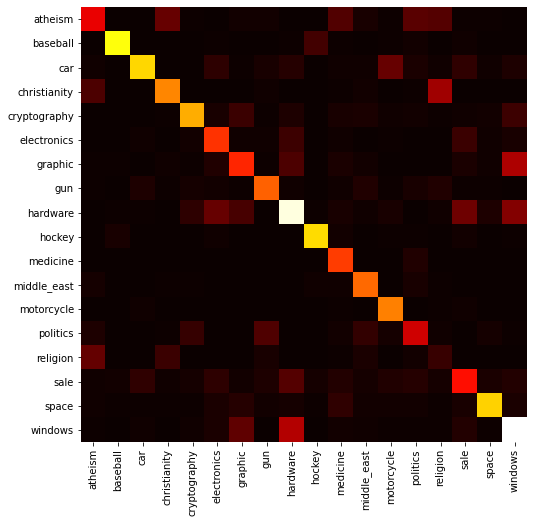

In [178]:
cm = confusion_matrix(prediction_labels_filtered, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [232]:
%%time
predictions_combined = generate_predictions_combined(data_20ng)
prediction_labels_comined = [labels[p] for p in predictions_combined]

print(classification_report(prediction_labels_comined, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.392     0.389     0.390       483
    baseball      0.811     0.818     0.814       592
         car      0.754     0.542     0.631       826
christianity      0.671     0.502     0.575       800
cryptography      0.704     0.655     0.679       640
 electronics      0.320     0.645     0.428       293
     graphic      0.443     0.391     0.416       662
         gun      0.700     0.621     0.658       615
    hardware      0.549     0.377     0.447      1702
      hockey      0.712     0.849     0.774       503
    medicine      0.559     0.824     0.666       403
 middle_east      0.569     0.735     0.641       437
  motorcycle      0.701     0.843     0.765       497
    politics      0.415     0.434     0.424       445
    religion      0.183     0.261     0.215       264
        sale      0.535     0.451     0.489       694
       space      0.712     0.560     0.627       754
     windows      0.343    